In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10
import re

In [2]:
house_data = pd.read_csv('house_data.csv',index_col = 0)

In [3]:
house_data.head()

,Antal rum,Avgift/månad,Begärt pris,Boarea,Byggår,Driftskostnad,Förening,Pris per kvadratmeter,Prisutveckling,address,coordinate,id,map_url,price,sale_date,type,url,Biarea,Tomtarea
938778,4 rum,5 604 kr/mån,2 475 000 kr,103 m2,2008,9 600 kr/år,\n Brf Höjdpunkten\n,24 757 kr/m2,\n\n +75 000 kr (+3 %)\n,Björkhagegatan 6,"[57.92291326887233, 12.502651264129536]",938778.0,https://maps.googleapis.com/maps/api/js?librar...,2550000.0,Såld 2019-01-28,bostadsratt,/salda/bostadsratt-4rum-stadsskogen-alingsas-k...,NaN,NaN
938744,7 rum,NaN,1 995 000 kr,175 m2,1958,52 400 kr/år,NaN,13 029 kr/m2,\n\n +285 000 kr (+14 %)\n,Ekebackevägen 1,"[58.47241420896091, 11.669846459571746]",938744.0,https://maps.googleapis.com/maps/api/js?librar...,2280000.0,Såld 2019-01-28,villa,/salda/villa-7rum-lilla-foss-munkedals-kommun-...,145 m2,1 483 m2
938717,5 rum,NaN,3 495 000 kr,103 m2,1979,38 865 kr/år,NaN,32 330 kr/m2,\n\n -165 000 kr (-5 %)\n,Agnebäcksvägen 24,"[57.69013704556706, 12.208904027993107]",938717.0,https://maps.googleapis.com/maps/api/js?librar...,3330000.0,Såld 2019-01-28,radhus,/salda/radhus-5rum-landvetter-harryda-kommun-a...,NaN,201 m2
938962,5 rum,NaN,2 275 000 kr,137 m2,1980,36 000 kr/år,NaN,16 606 kr/m2,\n,Tvåöringsgränd 12,"[58.377188776295206, 11.952471921867492]",938962.0,https://maps.googleapis.com/maps/api/js?librar...,2275000.0,Såld 2019-01-28,villa,/salda/villa-5rum-helenedal-uddevalla-kommun-t...,21 m2,346 m2
938923,3 rum,4 492 kr/mån,2 650 000 kr,70 m2,2016,NaN,\n BRF Lergöken\n,40 000 kr/m2,\n\n +150 000 kr (+6 %)\n,Lergöksgatan 15,"[57.65738875448929, 11.9003493296695]",938923.0,https://maps.googleapis.com/maps/api/js?librar...,2800000.0,Såld 2019-01-28,bostadsratt,/salda/bostadsratt-3rum-frolunda-goteborgs-kom...,NaN,NaN


In [4]:
regexp = re.compile('(\d+)')

def find_numbers(text):

    if pd.isnull(text):
        return text
    
    try:
        text_ = re.sub('m2','',text)
    except:
        return text
    
    try:
        results = regexp.findall(text_)
    except:
        return text_
    
    price_str = ''
    for result in results:
        price_str+=result
    
    try:
        price = float(price_str)
    except:
        price = None
    
    return price

In [5]:
date_regexp = re.compile('(\d\d\d\d-\d\d-\d\d)')
def find_date(date_string):
    result = date_regexp.search(date_string)
    return result.group(1)



In [6]:
house_data['sale_date'] = pd.to_datetime(house_data['sale_date'].apply(func = find_date))



In [7]:
col_names = ['Antal rum','Avgift/månad','Begärt pris','Boarea','Byggår','Driftskostnad','Pris per kvadratmeter','price','Tomtarea','Biarea']

for col_name in col_names:
    house_data[col_name] = house_data[col_name].apply(find_numbers)

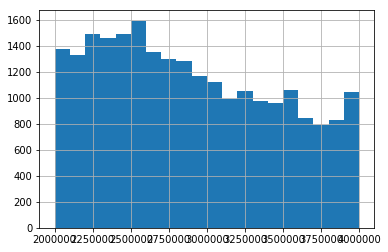

In [8]:
fig,ax = plt.subplots()
house_data['price'].hist(bins = 20,ax = ax)

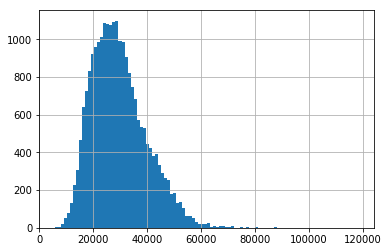

In [9]:
fig,ax = plt.subplots()
house_data['Pris per kvadratmeter'].hist(bins = 100,ax = ax)

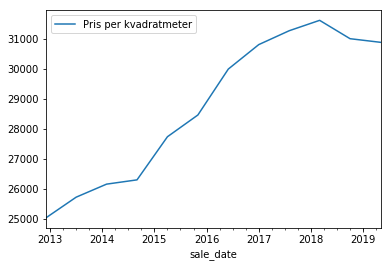

In [10]:
fig,ax = plt.subplots()
mask = house_data['Pris per kvadratmeter'] < 70000
house_data_ = house_data.loc[mask].copy()
house_data_ = house_data_.set_index('sale_date')

house_data_.resample('7M').mean().plot(y = 'Pris per kvadratmeter',ax = ax,alpha=1)

In [18]:
df = pd.read_csv('all_house_data.csv')
df.describe()

,Antal rum,Begärt pris,Biarea,Boarea,Byggår,Driftskostnad,Pris per kvadratmeter,Prisutveckling,Tomtarea,address,coordinate,id,map_url,price,sale_date,type,url,Avgift/månad,Förening
count,845,761,446,848,807,708,786,817,491,851,852,852,852,852,852,852,743,534,411
unique,17,418,268,307,193,527,742,575,444,828,835,689,128,362,25,155,730,472,369
top,2 rum,1 995 000 kr,Biarea,66 m2,1964,3 600 kr/år,Pris per kvadratmeter,\n,\n,address,coordinate,https://maps.googleapis.com/maps/api/js?librar...,https://maps.googleapis.com/maps/api/js?librar...,Såld 2019-01-23,bostadsratt,bostadsratt,url,Avgift/månad,Förening
freq,197,18,10,16,22,22,12,98,24,13,13,150,686,50,99,439,13,11,11
